In [1]:
from keras.datasets import mnist  # Use the Keras (ML) toolkit to get MNIST
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import random

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


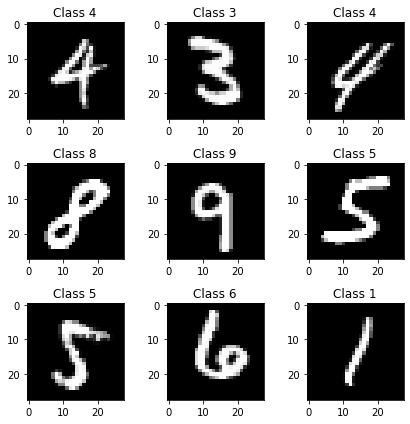

In [3]:
# Adopted from: https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb

plt.rcParams['figure.figsize'] = (6, 6)

for i in range(9):
    plt.subplot(3, 3, i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

(array([65026.,  1022.,   833.,   716.,   798.,   816.,   746.,   836.,
         1063.,  6544.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

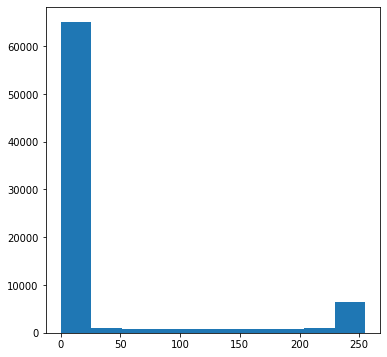

In [ ]:
# How are the pixel values distributed? Check a random sample.
plt.hist(X_train[:100].reshape(-1))

In [ ]:
# Flatten X features.
X_train = X_train.reshape(-1, 28 ** 2)
X_test = X_test.reshape(-1, 28 ** 2)

In [ ]:
# Let's start with a Gaussian classifier.
from sklearn.naive_bayes import GaussianNB

model = GaussianNB(var_smoothing=0.1)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.814

In [ ]:
# How about a Bernoulli fit on discretized features?
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB(alpha=1)

X_train_discrete = (X_train >= 128).astype(int)
X_test_discrete = (X_test >= 128).astype(int)
model.fit(X_train_discrete, y_train)
model.score(X_test_discrete, y_test)

0.8427

In [ ]:
# Let's take a look at the model-learned class prior probabilities.
np.exp(model.class_log_prior_)

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

In [ ]:
# How about the features?
print(model.feature_log_prob_.shape)
np.exp(model.feature_log_prob_)  # Uh-oh, too many to inspect.

(10, 784)


array([[0.00016878, 0.00016878, 0.00016878, ..., 0.00016878, 0.00016878,
        0.00016878],
       [0.00014828, 0.00014828, 0.00014828, ..., 0.00014828, 0.00014828,
        0.00014828],
       [0.00016779, 0.00016779, 0.00016779, ..., 0.00016779, 0.00016779,
        0.00016779],
       ...,
       [0.00015957, 0.00015957, 0.00015957, ..., 0.00015957, 0.00015957,
        0.00015957],
       [0.00017085, 0.00017085, 0.00017085, ..., 0.00017085, 0.00017085,
        0.00017085],
       [0.00016804, 0.00016804, 0.00016804, ..., 0.00016804, 0.00016804,
        0.00016804]])

In [ ]:
# Maybe look at outliers?
probs = np.exp(model.feature_log_prob_)
print(f'Highest 3 pixel coefficients per class: {probs.argsort()[:, -3:]}')
print(f'Example of probabilities for the first class: {probs[0, probs.argsort()[0, -3:]]}')

Highest 3 pixel coefficients per class: [[598 628 627]
 [434 378 406]
 [571 462 570]
 [350 351 378]
 [437 464 436]
 [374 347 375]
 [574 573 572]
 [268 464 269]
 [434 406 433]
 [436 381 409]]
Example of probabilities for the first class: [0.79021097 0.80877637 0.81232068]


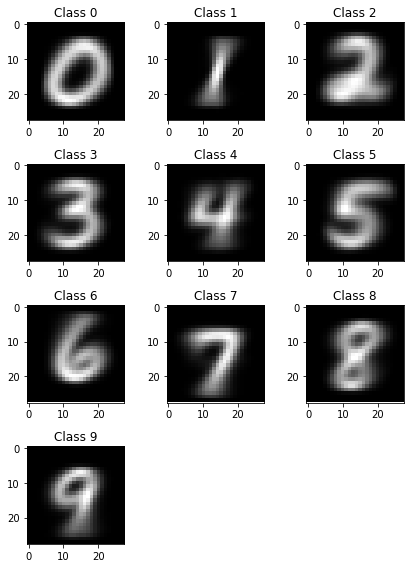

In [ ]:
# Let's print each pixel by its class-specific weight.
plt.rcParams['figure.figsize'] = (6, 8)  # Give ourselves a bit more vertical space.

for i in range(10):
    plt.subplot(4, 3, i + 1)
    plt.imshow(np.exp(model.feature_log_prob_[i]).reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Class {}".format(i))

plt.tight_layout()

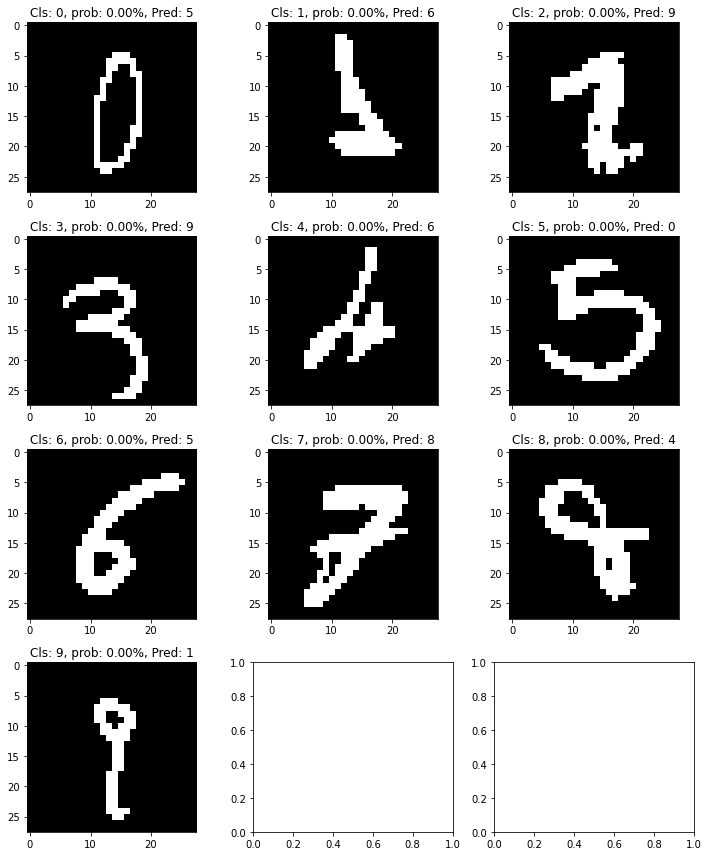

In [ ]:
# How about some mispredictions.
num_samples = 1000  # Let's focus on a subset of samples.
# Get the probability vector (over labels) assigned by the model to each sample,
predicted_probs = model.predict_proba(X_test_discrete)[:num_samples]
# and then extract the probability it assigned to the real label.
predicted_probs_of_targets = predicted_probs[range(num_samples), y_test[:num_samples]]

# Find the image with the worst probability for each label.
worst_predictions_by_label = {}
for label, (ix, prob) in zip(y_test[:num_samples], enumerate(predicted_probs_of_targets)):
  if label not in worst_predictions_by_label or worst_predictions_by_label[label][1] > prob:
    worst_predictions_by_label[label] = (ix, prob)

# Plot the worst-performing images.
plt.rcParams['figure.figsize'] = (10, 12)
_, axs = plt.subplots(nrows=4, ncols=3) # two axes on figure

for label, (worst_ix, prob) in worst_predictions_by_label.items():
  prediction = predicted_probs[worst_ix].argmax()
  ax = axs[label // 3, label % 3]
  ax.imshow(X_test_discrete[worst_ix].reshape(28, 28), cmap='gray', interpolation='none')
  ax.set_title(f'Cls: {label}, prob: {prob:.2%}, Pred: {prediction}')

plt.tight_layout()

In [ ]:
# How about a logistic regression model?
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
  penalty="l2",
	class_weight=None,
	random_state=0,
	solver="lbfgs",
	multi_class="multinomial",
	max_iter=500)

model.fit(X_train[:5000], y_train[:5000])  # Train on a subset to spare CPU time.

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, multi_class='multinomial', random_state=0)

In [ ]:
model.score(X_test, y_test)

0.8732

In [ ]:
print(model.coef_.shape)  # Hm, very big again. Let's try a similar trick.

print(f'Highest 3 pixel coefficients per class: {model.coef_.argsort()[:, -3:]}')
print(f'Example of highest values for the first class: {model.coef_[0, model.coef_.argsort()[0, -3:]]}')
# Hm, these aren't probabilities. What to do instead?

(10, 784)
Highest 3 pixel coefficients per class: [[330 540 656]
 [130 595 434]
 [427 623 361]
 [631 412 680]
 [463 411 376]
 [249 276 305]
 [544 631 459]
 [747 326 316]
 [656 321 275]
 [317 321 715]]
Example of highest values for the first class: [0.01705998 0.01732018 0.01811876]


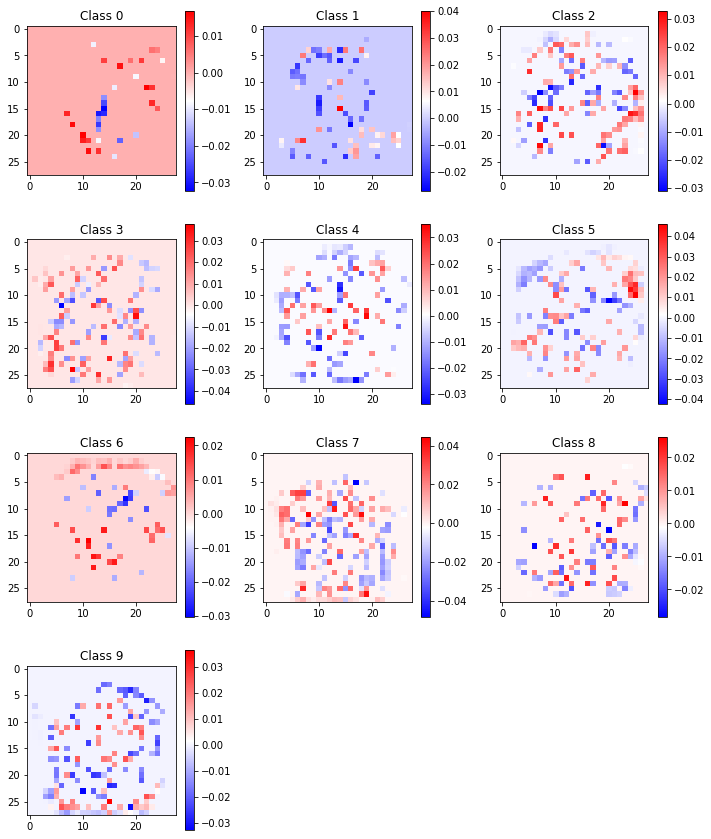

In [ ]:
# Let's print each pixel by its highest & lowest class-associated weight.
highest_coef = model.coef_.argmax(axis=0)
lowest_coef = (-model.coef_).argmax(axis=0)

plt.rcParams['figure.figsize'] = (10, 12)

for i in range(10):
    plt.subplot(4, 3, i + 1)
    highest_features = model.coef_[i] * (highest_coef == i)
    lowest_features = model.coef_[i] * (lowest_coef == i)
    plt.imshow((highest_features + lowest_features).reshape(28, 28), cmap='bwr', interpolation='none')
    plt.colorbar()
    plt.title("Class {}".format(i))

plt.tight_layout()
# Not extremely informative, but pretty useful for studying misclassifications.

In [ ]:
# Just for fun, how good is kNN for this task?
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train[:50000], y_train[:50000])  # Note how fast fitting  the model is! No weights to learn.
model.score(X_test, y_test)  # But, you do pay the price down the line. Efficient data structures can move most of this cost to "training".

0.9664